**Module import**

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, Model
#import tensorflow.keras.preprocessing.image as prep 
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt

#from models import Generator_mnist, Discriminator_mnist
#from data_load import get_npdata, get_data_list, load_celeba_to_np

from IPython import display

**Set Parameter**

In [ ]:
learning_rate = 0.0001  # alpha
gp_lambda = 10          # gradient penalty coefficient
n_critic = 5
b_1 = 0                 # Adam arg beta1
b_2 = 0.9               # Adam arg beta2
epochs = 5
batch_size = 64
noise_dim = 100
num_examples_to_generate = 16
BUFFER_SIZE = 60000     # mnist buffer size

**Data Load: MNIST**

In [ ]:
(train_images, _), (_, _) = mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # image normalization [-1, 1]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(batch_size)

11493376/11490434 [==============================] - 0s 0us/step


----------아직 사용 X, 여기부터----------

**Equalized Learning Rate**

In [ ]:
def equalize_learning_rate(shape, gain, fan_in=None):
    if fan_in is None: fan_in = np.prod(shape[:-1])
    std = gain / K.sqrt(fan_in)
    wscale = K.constant(std, name='wscale', dtype=np.float32)
    adjusted_weights = K.get_value('layer', shape=shape,
        initializer=tf.initializers.random_normal()) * wscale
    return adjusted_weights

**PixelNormalization**

In [ ]:
def pixelwise_feat_norm(inputs, **kwargs):
    '''
    Uses pixelwise feature normalization as proposed by
    Krizhevsky et at. 2012. Returns the input normalized
    :inputs     :    Keras / TF Layers
    '''
    normalization_constant = K.backend.sqrt(K.backend.mean(
        inputs**2, axis=-1, keepdims=True) + 1.0e-8)
    return inputs / normalization_constant

**MinibatchSTDDEV**

In [ ]:
def minibatch_std_layer(layer, group_size=4):
    group_size = K.backend.minimum(group_size, tf.shape(layer)[0])

    shape = list(K.int_shape(input))
    shape[0] = tf.shape(input)[0]


    minibatch = K.backend.reshape(layer,
        (group_size, -1, shape[1], shape[2], shape[3]))
    minibatch -= tf.reduce_mean(minibatch, axis=0, keepdims=True)
    minibatch = tf.reduce_mean(K.backend.square(minibatch), axis = 0)
    minibatch = K.backend.square(minibatch + 1e8)
    minibatch = tf.reduce_mean(minibatch, axis=[1,2,4], keepdims=True)
    minibatch = K.backend.tile(minibatch,
        [group_size, 1, shape[2], shape[3]])
    return K.backend.concatenate([layer, minibatch], axis=1)

**Upsample, Downsample**

In [ ]:
def upscale_layer(layer, upscale_factor):
    height = layer.get_shape()[1]
    width = layer.get_shape()[2]
    size = (upscale_factor * height, upscale_factor * width)
    upscaled_layer = tf.image.resize_nearest_neighbor(layer, size)
    return upscaled_layer

def smoothly_merge_last_layer(list_of_layers, alpha):
    last_fully_trained_layer = list_of_layers[-2]
    last_layer_upscaled = upscale_layer(last_fully_trained_layer, 2)

    larger_native_layer = list_of_layers[-1]

    assert larger_native_layer.get_shape() == last_layer_upscaled.get_shape()

    new_layer = (1-alpha) * upscaled_layer + larger_native_layer * alpha

    return new_layer

----------아직 사용 X, 여기까지----------

**Generator**

In [ ]:
#NOISE_DIM = 512

In [ ]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x
    
def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model

**Discriminator**

In [ ]:
IMG_SHAPE = (28, 28, 1)

In [ ]:
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model

↓PGGAN 관련 코드이나 아직 해결 하지 못하였음.

In [ ]:
'''
def model_builder(target_resolution):
    generator = None
    discriminator = None
    if target_resolution == 4:
        generator = build_4x4_generator()
        discriminator = build_4x4_discriminator()
    elif target_resolution == 8:
        generator = build_8x8_generator()
        discriminator = build_8x8_discriminator()
    elif target_resolution == 16:
        generator = build_16x16_generator()
        discriminator = build_16x16_discriminator()
    elif target_resolution == 32:
        generator = build_32x32_generator()
        discriminator = build_32x32_discriminator()
    elif target_resolution == 64:
        generator = build_64x64_generator()
        discriminator = build_64x64_discriminator()
    elif target_resolution == 128:
        generator = build_128x128_generator()
        discriminator = build_128x128_discriminator()
    elif target_resolution == 256:
        generator = build_256x256_generator()
        discriminator = build_256x256_discriminator()
    elif target_resolution == 512:
        generator = build_512x512_generator()
        discriminator = build_512x512_discriminator()
    else:
        print("target resolution models are not defined yet")
    return generator, discriminator
    '''

**Model load & Summary**

In [ ]:
#image_size = 4

In [ ]:
# model load
G = get_generator_model()
D = get_discriminator_model()
#G, D = model_builder(image_size)

input1 = tf.keras.Input(shape=(100))
input2 = tf.keras.Input(shape=(28, 28, 1))

x1 = G(input1)
x2 = D(input2)

G.summary()
D.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_5 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         29

**Optimizer: Adam**

In [ ]:
# Set optimizer
generator_optimizer = keras.optimizers.Adam(learning_rate, beta_1 = b_1, beta_2 = b_2)
discriminator_optimizer = keras.optimizers.Adam(learning_rate, beta_1 = b_1, beta_2 = b_2)

**고정된 seed에 대해 결과 이미지 변화**

In [ ]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # mnist
        plt.imshow(predictions[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

**Checkpoint Setting**

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 G=G,
                                 D=D)

**Train step function & loss**

In [ ]:
def discriminator_train_step(images):
    len_batch = len(images)    # 마지막 batch에서의 length를 맞춰주기 위함
    noise = tf.random.normal([len_batch, noise_dim]) 
    
    with tf.GradientTape() as disc_tape:
        D.training = True
        generated_images = G(noise)
        real_output = D(images)
        fake_output = D(generated_images)
    
        #wgan loss
        disc_loss = K.mean(fake_output) - K.mean(real_output)

        eps = tf.random.uniform(shape=[len_batch, 1, 1, 1])
        x_hat = eps*images + (1 - eps)*generated_images
        
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = D(x_hat)

        gradients = t.gradient(d_hat, [x_hat])  # gradients 계산
        l2_norm = K.sqrt(K.sum(K.square(gradients), axis=[2,3]))
        l2_norm = K.squeeze(l2_norm, axis=0)
        gradient_penalty = K.sum(K.square((l2_norm-1.)), axis=[1])
        disc_loss += gp_lambda*gradient_penalty
                
    gradients_of_discriminator = disc_tape.gradient(disc_loss, D.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, D.trainable_variables))
    
    return K.sum(disc_loss)

In [ ]:
def generator_train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape:
        G.training = True
        generated_images = G(noise)
        fake_output = D(generated_images)
        
        #wgan loss
        gen_loss = - K.mean(fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, G.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, G.trainable_variables))    
    
    return K.sum(gen_loss)

**Training**

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_list = []
        disc_loss_list = []
        
        for image_batch in train_dataset:
            loss_d = 0
            for i in range(n_critic):
                loss_d += discriminator_train_step(image_batch)
            loss_g = generator_train_step(image_batch)
        
            gen_loss_list.append(loss_g)
            disc_loss_list.append(loss_d / n_critic)
            
        # 이미지 생성
        display.clear_output(wait=True)
        generate_and_save_images(G, epoch + 1, seed)
        
        # 15 epochs 지날 때마다 모델 저장
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        # loss & 시간 출력
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print ('G_Loss is {}, D_Loss is {}'.format(sum(gen_loss_list)/len(gen_loss_list), 
                                                   sum(disc_loss_list)/len(disc_loss_list)))

    # 학습이 끝난 후 이미지 생성
    display.clear_output(wait=True)
    generate_and_save_images(G, epochs, seed)

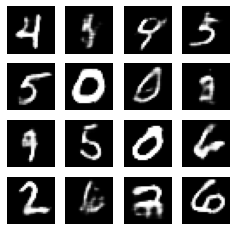

CPU times: user 20min 33s, sys: 17.1 s, total: 20min 50s
Wall time: 33min 7s


In [ ]:
%%time
train(train_dataset, epochs)